In [1]:
import pandas as pd
import numpy as np
import nltk
import re
import string

### For some reason, there are broken table tags in a lot of the tables below when they're rendered on Github. They don't actually look like that

In [2]:
df = pd.read_csv('../data/JEOPARDY_CSV.csv', encoding='utf-8')
# full_df = pd.read_csv('../data/JEOPARDY_CSV.csv', encoding='utf-8')
# print full_df.shape
# full_df.head()

In [3]:
# df = full_df.sample(frac=0.1)
# df.reset_index(drop=True, inplace=True)

In [4]:
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,$200,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,$200,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,$200,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,$200,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,$200,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [5]:
# Remove the dumb spaces
df.columns = ['Show Number', 'Air Date', 'Round', 'Category', 'Value', 'Question', 'Answer']

# Convert to Datetime
df['Air Date'] = pd.to_datetime(df['Air Date'])

# Clean out Value column
df['Value'] = df['Value'].str.replace('$','')
df['Value'] = df['Value'].str.replace(',','')
df['Value'] = df['Value'].apply(lambda x: None if x == 'None' else int(x))
df.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer
0,4680,2004-12-31,Jeopardy!,HISTORY,200.0,"For the last 8 years of his life, Galileo was ...",Copernicus
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200.0,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200.0,The city of Yuma in this state has a record av...,Arizona
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200.0,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200.0,"Signer of the Dec. of Indep., framer of the Co...",John Adams


In [6]:
df['Question'].value_counts()[0:5]

[audio clue]     17
[video clue]     14
[filler]          5
(audio clue)      5
Abigail Smith     4
Name: Question, dtype: int64

In [7]:
df.shape

(216930, 7)

In [8]:
# Drop some useless questions
df = df[df['Question'] != '[audio clue]']
df = df[df['Question'] != '[video clue]']
df = df[df['Question'] != '[filler]']
df = df[df['Question'] != '(audio clue)']

In [9]:
df.shape

(216889, 7)

In [10]:
# load nltk's English stopwords as variable called 'stopwords'
stopwords = nltk.corpus.stopwords.words('english')
print len(stopwords)
print stopwords[:10]

153
[u'i', u'me', u'my', u'myself', u'we', u'our', u'ours', u'ourselves', u'you', u'your']


In [11]:
# load nltk's SnowballStemmer as variabled 'stemmer'
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

In [12]:
# here I define a tokenizer and stemmer which returns the set of stems in the text that it is passed

def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems


def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [13]:
def create_clean_columns(df):    
    df['clean_question'] = df['Question'].apply(cleanhtml)
    df['clean_answer'] = df['Answer'].apply(cleanhtml)
    df['clean_category'] = df['Category'].apply(cleanhtml)
    df['everything'] = df['clean_question']+' '+df['clean_answer']+' '+df['clean_category']
    return df

def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    cleantext = cleantext.replace('\n', '')
    cleantext = cleantext.replace('-', ' ')
#     cleantext = cleantext.translate(None, string.punctuation)
#     cleantext = cleantext.replace('\'', '')
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    cleantext = regex.sub('', cleantext)
    cleantext = cleantext.lower()
    return cleantext

In [14]:
create_clean_columns(df)

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_category,everything
0,4680,2004-12-31,Jeopardy!,HISTORY,200.0,"For the last 8 years of his life, Galileo was ...",Copernicus,for the last 8 years of his life galileo was u...,copernicus,history,for the last 8 years of his life galileo was u...
1,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,200.0,No. 2: 1912 Olympian; football star at Carlisl...,Jim Thorpe,no 2 1912 olympian football star at carlisle i...,jim thorpe,espns top 10 all time athletes,no 2 1912 olympian football star at carlisle i...
2,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,200.0,The city of Yuma in this state has a record av...,Arizona,the city of yuma in this state has a record av...,arizona,everybody talks about it,the city of yuma in this state has a record av...
3,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,200.0,"In 1963, live on ""The Art Linkletter Show"", th...",McDonald's,in 1963 live on the art linkletter show this c...,mcdonalds,the company line,in 1963 live on the art linkletter show this c...
4,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,200.0,"Signer of the Dec. of Indep., framer of the Co...",John Adams,signer of the dec of indep framer of the const...,john adams,epitaphs tributes,signer of the dec of indep framer of the const...
5,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,200.0,"In the title of an Aesop fable, this insect sh...",the ant,in the title of an aesop fable this insect sha...,the ant,3 letter words,in the title of an aesop fable this insect sha...
6,4680,2004-12-31,Jeopardy!,HISTORY,400.0,Built in 312 B.C. to link Rome & the South of ...,the Appian Way,built in 312 bc to link rome the south of ita...,the appian way,history,built in 312 bc to link rome the south of ita...
7,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,400.0,"No. 8: 30 steals for the Birmingham Barons; 2,...",Michael Jordan,no 8 30 steals for the birmingham barons 2306 ...,michael jordan,espns top 10 all time athletes,no 8 30 steals for the birmingham barons 2306 ...
8,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,400.0,"In the winter of 1971-72, a record 1,122 inche...",Washington,in the winter of 1971 72 a record 1122 inches ...,washington,everybody talks about it,in the winter of 1971 72 a record 1122 inches ...
9,4680,2004-12-31,Jeopardy!,THE COMPANY LINE,400.0,This housewares store was named for the packag...,Crate & Barrel,this housewares store was named for the packag...,crate barrel,the company line,this housewares store was named for the packag...


In [15]:
questions = df['clean_question'].values
# questions = df['everything'].values
categories = df['clean_category'].values
answers = df['clean_answer'].values

In [16]:
# nltk.tag.pos_tag(questions[0].split())

In [17]:
# nouns_only = []
# for i in range(len(questions)):
#     nouns_only.append([w[0] for w in nltk.tag.pos_tag(questions[i].split()) if w[1] in ['NN', 'NNS', 'NNP', 'NNPS']])

In [18]:
# for i in range(len(nouns_only)):
#     nouns_only[i] = ' '.join(nouns_only[i])

In [19]:
# nouns_only = filter(None, nouns_only)

In [20]:
#use extend so it's a big flat list of vocab
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in questions:
    allwords_stemmed = tokenize_and_stem(i) #for each item in 'questions', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

In [21]:
# parts = nltk.tag.pos_tag(totalvocab_tokenized)

In [22]:
vocab_frame = pd.DataFrame(totalvocab_tokenized, index = totalvocab_stemmed, columns=['Words'])

In [23]:
vocab_frame.shape

(3013774, 1)

In [24]:
vocab_frame.head(20)

,Words
for,for
the,the
last,last
year,years
of,of
his,his
life,life
galileo,galileo
was,was
under,under


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.externals import joblib

# tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=100000,
#                                  min_df=0.001, stop_words='english',
#                                  use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=100000, use_idf=True,
                                 tokenizer=tokenize_and_stem, ngram_range=(1,3))

# tfidf_vectorizer = TfidfVectorizer(stop_words='english',
#                                  tokenizer=tokenize_only, ngram_range=(1,3))

# %time tfidf_matrix = tfidf_vectorizer.fit_transform(questions)

%time tfidf_vectorizer.fit(questions)
# tfidf_vectorizer.fit(nouns_only)

# More memory efficient to dump the model and then load it
joblib.dump(tfidf_vectorizer, 'tfidf_test.pkl')

CPU times: user 1min 54s, sys: 1.12 s, total: 1min 55s
Wall time: 1min 55s


['tfidf_test.pkl', 'tfidf_test.pkl_01.npy', 'tfidf_test.pkl_02.npy']

In [26]:
tfidf_vectorizer = joblib.load('tfidf_test.pkl')
%time tfidf_matrix = tfidf_vectorizer.transform(questions)
# tfidf_matrix = tfidf_vectorizer.transform(nouns_only)

CPU times: user 1min 35s, sys: 376 ms, total: 1min 36s
Wall time: 1min 35s


In [27]:
tfidf_matrix.shape

(216889, 100000)

In [28]:
terms = tfidf_vectorizer.get_feature_names()

In [29]:
# from sklearn.metrics.pairwise import cosine_similarity
# dist = 1 - cosine_similarity(tfidf_matrix)

In [30]:
# from sklearn.feature_extraction.text import CountVectorizer

# count_vectorizer = CountVectorizer(stop_words='english', max_features=100000)

In [31]:
from sklearn.metrics import silhouette_score

def silhouette_selection(x, k):
    scores = []
    for iteration in range(50, k, 10):
        print('Number of clusters: %s' % iteration)
#         km = KMeans(n_clusters=iteration)
#         km.fit(x)
#         sil_score = silhouette_score(x, km.labels_)
        agglo = AgglomerativeClustering(n_clusters=iteration)
        agglo.fit(tsvd_matrix)
        sil_score = silhouette_score(x, agglo.labels_)
        print(sil_score)
        scores.append((iteration, sil_score))
    return scores

In [32]:
# sil_scores = silhouette_selection(tfidf_matrix, 160)

In [33]:
# min([x[1] for x in sil_scores])

In [34]:
from sklearn.decomposition import TruncatedSVD

tsvd = TruncatedSVD(n_components=700)
%time tsvd.fit(tfidf_matrix)
joblib.dump(tsvd, 'tsvd.pkl')

CPU times: user 1min 20s, sys: 3.65 s, total: 1min 24s
Wall time: 1min 8s


['tsvd.pkl', 'tsvd.pkl_01.npy', 'tsvd.pkl_02.npy', 'tsvd.pkl_03.npy']

In [35]:
tsvd = joblib.load('tsvd.pkl')
%time tsvd_matrix = tsvd.transform(tfidf_matrix)

CPU times: user 1.16 s, sys: 100 ms, total: 1.26 s
Wall time: 1.39 s


In [36]:
# tsvd.explained_variance_ratio_

In [37]:
np.cumsum(tsvd.explained_variance_ratio_)

array([ 0.00056053,  0.00187276,  0.00308598,  0.00426819,  0.00536737,
        0.00645185,  0.0075126 ,  0.00849406,  0.00946325,  0.01040786,
        0.01131072,  0.01220097,  0.01307322,  0.01391638,  0.0147576 ,
        0.01555913,  0.01634302,  0.01709871,  0.01783186,  0.01855086,
        0.0192535 ,  0.01995875,  0.02065257,  0.0213453 ,  0.0220355 ,
        0.02272065,  0.02340147,  0.02407323,  0.0247416 ,  0.02539856,
        0.02604529,  0.02667708,  0.02729802,  0.0279179 ,  0.02853227,
        0.02914437,  0.02975087,  0.03035503,  0.03095439,  0.03154703,
        0.03213322,  0.03271941,  0.0333013 ,  0.03388172,  0.03445901,
        0.03502813,  0.03559486,  0.03615826,  0.03671942,  0.03727413,
        0.0378275 ,  0.03837818,  0.03892566,  0.03947003,  0.04001053,
        0.04054666,  0.04107692,  0.04160509,  0.04213149,  0.04265525,
        0.04317755,  0.04369648,  0.04421419,  0.04472864,  0.04523955,
        0.04574662,  0.04625268,  0.04675434,  0.04725476,  0.04

In [38]:
from sklearn.preprocessing import StandardScaler

tsvd_word_data_standardized = StandardScaler().fit_transform(tsvd_matrix)

In [40]:
from sklearn.cluster import KMeans, MiniBatchKMeans, AgglomerativeClustering, DBSCAN

num_clusters = 100

In [50]:
km = KMeans(n_clusters=num_clusters, n_jobs=-1)
# minikm = MiniBatchKMeans(n_clusters=num_clusters)
# agglo = AgglomerativeClustering(n_clusters=num_clusters)
# db = DBSCAN(eps=0.3, min_samples=10)

%time km.fit(tfidf_matrix)
# %time minikm.fit(tfidf_matrix)
# %time agglo.fit(tsvd_matrix)
# %time db.fit(tfidf_matrix)

clusters = km.labels_.tolist()
# clusters = minikm.labels_.tolist()
# clusters = agglo.labels_.tolist()
# clusters = db.labels_.tolist()
joblib.dump(km, 'kmeans.pkl')

CPU times: user 2.76 s, sys: 1.82 s, total: 4.58 s
Wall time: 9min 59s


['kmeans.pkl', 'kmeans.pkl_01.npy', 'kmeans.pkl_02.npy']

In [51]:
tsvd_matrix.shape

(216889, 500)

In [52]:
agglo = AgglomerativeClustering(n_clusters=num_clusters)#, memory=joblib.Memory(cachedir='/tmp/memory_cache'))

In [53]:
# %time agglo.fit(tsvd_matrix)
# clusters = agglo.labels_.tolist()

In [54]:
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

In [55]:
# db = DBSCAN(eps=0.3, min_samples=10).fit(X)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

# # Number of clusters in labels, ignoring noise if present.
# n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

# print('Estimated number of clusters: %d' % n_clusters_)
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
# print("Silhouette Coefficient: %0.3f"
#       % metrics.silhouette_score(X, labels))


In [56]:
# km.predict(df['clean_question'].values)

In [57]:
df['Cluster'] = clusters

In [58]:
df['Cluster'].value_counts()

76    72355
53     2895
91     2824
59     2801
39     2739
93     2662
90     2658
20     2657
42     2615
5      2601
34     2496
51     2373
1      2299
52     2236
62     2165
23     2133
36     2035
14     2032
82     2019
37     1976
28     1971
86     1970
19     1962
57     1958
12     1933
26     1920
21     1916
16     1890
85     1888
41     1879
      ...  
71     1056
25     1046
80     1035
61     1033
17     1029
8      1027
47     1004
7       998
43      975
79      906
13      896
11      865
77      858
3       837
54      832
44      825
92      812
87      803
89      787
70      769
68      751
45      751
94      725
67      656
49      643
95      492
56      489
97      339
24      281
10        7
Name: Cluster, dtype: int64

In [59]:
df[df['Cluster'] == 76]

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_category,everything,Cluster
5,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,200.0,"In the title of an Aesop fable, this insect sh...",the ant,in the title of an aesop fable this insect sha...,the ant,3 letter words,in the title of an aesop fable this insect sha...,76
7,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,400.0,"No. 8: 30 steals for the Birmingham Barons; 2,...",Michael Jordan,no 8 30 steals for the birmingham barons 2306 ...,michael jordan,espns top 10 all time athletes,no 8 30 steals for the birmingham barons 2306 ...,76
10,4680,2004-12-31,Jeopardy!,EPITAPHS & TRIBUTES,400.0,"""And away we go""",Jackie Gleason,and away we go,jackie gleason,epitaphs tributes,and away we go jackie gleason epitaphs tributes,76
11,4680,2004-12-31,Jeopardy!,3-LETTER WORDS,400.0,Cows regurgitate this from the first stomach t...,the cud,cows regurgitate this from the first stomach t...,the cud,3 letter words,cows regurgitate this from the first stomach t...,76
14,4680,2004-12-31,Jeopardy!,EVERYBODY TALKS ABOUT IT...,600.0,"On June 28, 1994 the nat'l weather service beg...",the UV index,on june 28 1994 the natl weather service began...,the uv index,everybody talks about it,on june 28 1994 the natl weather service began...,76
19,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,800.0,No. 10: FB/LB for Columbia U. in the 1920s; MV...,(Lou) Gehrig,no 10 fblb for columbia u in the 1920s mvp for...,lou gehrig,espns top 10 all time athletes,no 10 fblb for columbia u in the 1920s mvp for...,76
25,4680,2004-12-31,Jeopardy!,ESPN's TOP 10 ALL-TIME ATHLETES,1000.0,No. 5: Only center to lead the NBA in assists;...,(Wilt) Chamberlain,no 5 only center to lead the nba in assists tr...,wilt chamberlain,espns top 10 all time athletes,no 5 only center to lead the nba in assists tr...,76
29,4680,2004-12-31,Double Jeopardy!,DR. SEUSS AT THE MULTIPLEX,400.0,"<a href=""http://www.j-archive.com/media/2004-1...",Horton,beyond ovoid abandonment beyond ovoid betrayal...,horton,dr seuss at the multiplex,beyond ovoid abandonment beyond ovoid betrayal...,76
30,4680,2004-12-31,Double Jeopardy!,PRESIDENTIAL STATES OF BIRTH,400.0,California,Nixon,california,nixon,presidential states of birth,california nixon presidential states of birth,76
31,4680,2004-12-31,Double Jeopardy!,AIRLINE TRAVEL,400.0,It can be a place to leave your puppy when you...,a kennel,it can be a place to leave your puppy when you...,a kennel,airline travel,it can be a place to leave your puppy when you...,76


In [60]:
# from sklearn.metrics import silhouette_score

# silhouette_score(tfidf_matrix, km.labels_)

In [61]:
from __future__ import print_function

cluster_words = []
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    cluster_words.append([])
    for ind in order_centroids[i, :10]: #replace 10 with n words per cluster
#         print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0], end=',')
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
#         cluster_words[i].append('%s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0])
        cluster_words[i].append('%s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'))
    print() #add whitespace
    print() #add whitespace
    
#     print("Cluster %d categories:" % i, end='')
#     for cat in df.ix[i]['Category']#.values.tolist():
#         print(' %s,' % title, end='')
#     print() #add whitespace
#     print() #add whitespace
    
# print()
# print()

Top terms per cluster:

Cluster 0 words: features, film, features, music, film, songs, star, seen, flag, stamp,

Cluster 1 words: like, look, look, just, just, shaped, use, said, shaped, say,

Cluster 2 words: home, city, city, state, universe, country, state, museum, country, home,

Cluster 3 words: led, revolts, mans, team, group, led, war, expedition, zeppelin, mans,

Cluster 4 words: dog, life, breed, dog, hot, breed, hot, real, novel, said,

Cluster 5 words: film, plays, title, based, director, role, film, directed, novel, actor,

Cluster 6 words: songs, hit, hit, songs, heard, title, theme, theme, songs, say,

Cluster 7 words: old, years, years, old, became, girl, years, old, west, old,

Cluster 8 words: killing, mans, king, peoples, killing, brothers, killing, battled, try, wife,

Cluster 9 words: john, adams, st, film, john, st, plays, elton, paul, elton,

Cluster 10 words: personification, weather, god, founders, very, nip, wintry, virtue, freezing, uranus,

Cluster 11 words: 

In [62]:
len(cluster_words)

100

In [63]:
cluster_names = []

for item in cluster_words:
    string = ''
    for i in item:
        string += i
        string += ' '
    cluster_names.append(string)

In [64]:
cluster_names

['features film features music film songs star seen flag stamp ',
 'like look look just just shaped use said shaped say ',
 'home city city state universe country state museum country home ',
 'led revolts mans team group led war expedition zeppelin mans ',
 'dog life breed dog hot breed hot real novel said ',
 'film plays title based director role film directed novel actor ',
 'songs hit hit songs heard title theme theme songs say ',
 'old years years old became girl years old west old ',
 'killing mans king peoples killing brothers killing battled try wife ',
 'john adams st film john st plays elton paul elton ',
 'personification weather god founders very nip wintry virtue freezing uranus ',
 'stand stand initials abbreviation m feet use lettered acronym seen ',
 'time magazine time years said mans good good only long ',
 'italian italian city pasta italian word italian term means use ',
 'island largest country rhode rhode island largest national island island ',
 'won awarded emmy

### Case study, one episode

In [89]:
print(min(df['Show Number']))
print(max(df['Show Number']))

1
6300


In [100]:
np.random.random_integers(6301)

/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: DeprecationWarning: This function is deprecated. Please call randint(1, 6301 + 1) instead
  if __name__ == '__main__':


5729

In [101]:
one_show = df[df['Show Number'] == 5729]

In [102]:
one_show['Category'].value_counts()

I'M FUNEMPLOYED                    5
LITERATURE IN THE 1800s            5
THE STATE'S POSTAL ABBREVIATION    5
RHYMELESS WORDS                    5
TASTY AD SLOGANS                   5
HAVOC                              5
COLLEGE FOOTBALL QUOTES            5
CRY                                5
MEDICAL PREFIXES & SUFFIXES        5
THE "DOG"S                         5
MARK ANTONY                        4
OF WAR                             3
U.S. TRANSPORTATION HISTORY        1
Name: Category, dtype: int64

In [103]:
one_show['Cluster'].value_counts()

76    18
16     4
8      3
86     3
39     2
92     2
18     1
81     1
73     1
63     1
71     1
6      1
69     1
4      1
67     1
1      1
85     1
24     1
61     1
25     1
91     1
29     1
96     1
37     1
40     1
32     1
46     1
48     1
53     1
54     1
57     1
0      1
Name: Cluster, dtype: int64

In [104]:
one_tfidf = TfidfVectorizer(stop_words='english', max_features=100000, use_idf=True,
                                 tokenizer=tokenize_and_stem, ngram_range=(1,3))

one_tfidf.fit(one_show['everything'].values)
one_tfidf_matrix = one_tfidf.transform(one_show['everything'].values)

In [105]:
one_km = KMeans(n_clusters=13, n_jobs=-1)
%time one_km.fit(one_tfidf_matrix)
one_show_clusters = one_km.labels_.tolist()

CPU times: user 308 ms, sys: 104 ms, total: 412 ms
Wall time: 665 ms


In [106]:
one_show['Cluster'] = one_show_clusters

/home/nick/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [107]:
one_show['Cluster'].value_counts()

2     6
12    5
10    5
7     5
4     5
3     5
1     5
0     5
11    4
9     4
5     4
8     3
6     2
Name: Cluster, dtype: int64

In [108]:
one_show.head()

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_category,everything,Cluster
18981,5729,2009-07-02,Jeopardy!,LITERATURE IN THE 1800s,200.0,"Stephen Crane subtitled this novel ""An Episode...",The Red Badge of Courage,stephen crane subtitled this novel an episode ...,the red badge of courage,literature in the 1800s,stephen crane subtitled this novel an episode ...,10
18982,5729,2009-07-02,Jeopardy!,COLLEGE FOOTBALL QUOTES,200.0,"A Buckeye at this school: ""I'm really happy fo...",Ohio State,a buckeye at this school im really happy for t...,ohio state,college football quotes,a buckeye at this school im really happy for t...,1
18983,5729,2009-07-02,Jeopardy!,TASTY AD SLOGANS,200.0,"""The best part of wakin' up is"" this beverage ...",Folgers,the best part of wakin up is this beverage in ...,folgers,tasty ad slogans,the best part of wakin up is this beverage in ...,12
18984,5729,2009-07-02,Jeopardy!,I'M FUNEMPLOYED,200.0,Move over Rachel Zoe--I love to work with cele...,a fashion stylist,move over rachel zoe i love to work with cele...,a fashion stylist,im funemployed,move over rachel zoe i love to work with cele...,6
18985,5729,2009-07-02,Jeopardy!,MEDICAL PREFIXES & SUFFIXES,200.0,"Following lump- & tonsil(l)-, it denotes a sur...",-ectomy,following lump tonsill it denotes a surgica...,ectomy,medical prefixes suffixes,following lump tonsill it denotes a surgica...,2


In [109]:
one_show[one_show['Cluster'] == 2]

,Show Number,Air Date,Round,Category,Value,Question,Answer,clean_question,clean_answer,clean_category,everything,Cluster
18985,5729,2009-07-02,Jeopardy!,MEDICAL PREFIXES & SUFFIXES,200.0,"Following lump- & tonsil(l)-, it denotes a sur...",-ectomy,following lump tonsill it denotes a surgica...,ectomy,medical prefixes suffixes,following lump tonsill it denotes a surgica...,2
18991,5729,2009-07-02,Jeopardy!,MEDICAL PREFIXES & SUFFIXES,400.0,"Coro-refers to the pupil of the eye; this, one...",colo-,coro refers to the pupil of the eye this one l...,colo,medical prefixes suffixes,coro refers to the pupil of the eye this one l...,2
18997,5729,2009-07-02,Jeopardy!,MEDICAL PREFIXES & SUFFIXES,600.0,"This suffix means ""disease""; when it follows o...",-pathic,this suffix means disease when it follows oste...,pathic,medical prefixes suffixes,this suffix means disease when it follows oste...,2
19003,5729,2009-07-02,Jeopardy!,MEDICAL PREFIXES & SUFFIXES,1200.0,"After my-, it means pain in the muscles; after...",-algia,after my it means pain in the muscles after n...,algia,medical prefixes suffixes,after my it means pain in the muscles after n...,2
19009,5729,2009-07-02,Jeopardy!,MEDICAL PREFIXES & SUFFIXES,1000.0,"Used as a suffix, -emia means pertaining to th...",blood,used as a suffix emia means pertaining to thi...,blood,medical prefixes suffixes,used as a suffix emia means pertaining to thi...,2
19038,5729,2009-07-02,Final Jeopardy!,U.S. TRANSPORTATION HISTORY,NaN,"Not standardized as the shape we know, the fir...",a stop sign,not standardized as the shape we know the firs...,a stop sign,us transportation history,not standardized as the shape we know the firs...,2


In [110]:
from sklearn.manifold import TSNE

In [111]:
one_tsne = TSNE()

graphing_data = one_tsne.fit_transform(one_tfidf_matrix.todense())

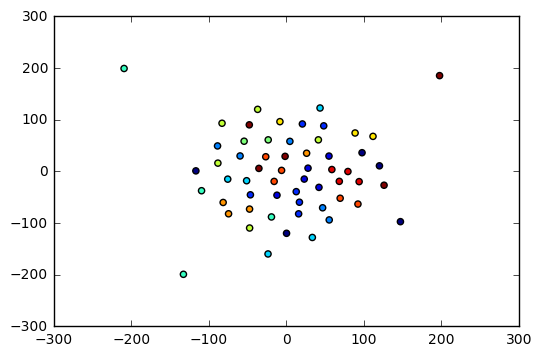

In [112]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(graphing_data[:,0], graphing_data[:,1], c=one_show_clusters) 

In [113]:
#use extend so it's a big flat list of vocab
one_totalvocab_stemmed = []
one_totalvocab_tokenized = []
for i in one_show['everything'].values:
    one_allwords_stemmed = tokenize_and_stem(i) #for each item in 'questions', tokenize/stem
    one_totalvocab_stemmed.extend(one_allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    one_allwords_tokenized = tokenize_only(i)
    one_totalvocab_tokenized.extend(one_allwords_tokenized)

In [114]:
one_terms = one_tfidf.get_feature_names()
one_vocab_frame = pd.DataFrame(one_totalvocab_tokenized, index = one_totalvocab_stemmed, columns=['Words'])
one_vocab_frame.head()

,Words
stephen,stephen
crane,crane
subtitl,subtitled
this,this
novel,novel


In [115]:
from __future__ import print_function

one_cluster_words = []
print("Top terms per cluster:")
print()
one_order_centroids = one_km.cluster_centers_.argsort()[:, ::-1] 

for i in range(13):
    print("Cluster %d words:" % i, end='')
    one_cluster_words.append([])
    for ind in one_order_centroids[i, :5]: #replace 10 with n words per cluster
        print(' %s' % one_vocab_frame.ix[one_terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
        one_cluster_words[i].append('%s' % one_vocab_frame.ix[one_terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'))
    print() #add whitespace
    print() #add whitespace

Top terms per cluster:

Cluster 0 words: dog, boondoggle, wasteful, fraudulent, project,

Cluster 1 words: college, college, college, football, football,

Cluster 2 words: suffixes, medical, medical, medical, prefixes,

Cluster 3 words: words, rhymeless, rhymeless, oven, oven,

Cluster 4 words: state, postal, postal, state, abbreviation,

Cluster 5 words: antony, marks, marks, bc, defeat,

Cluster 6 words: stylist, rachel, love, gosling, mcadams,

Cluster 7 words: havoc, killed, winter, destroyed, killed,

Cluster 8 words: weapon, war, fully, gauge, new,

Cluster 9 words: cry, film, popcorn, popcorn, ali,

Cluster 10 words: literature, 1800s, literature, translation, rosenborg,

Cluster 11 words: im, funemployed, im, coasters, coasters,

Cluster 12 words: ad, tasty, ad, tasty, tasty,



In [120]:
one_cluster_names = []

for item in one_cluster_words:
    string = ''
    for i in item:
        string += i
        string += ' '
    one_cluster_names.append(string)

In [121]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(one_tfidf_matrix)

In [122]:
one_cluster_dict = dict(zip(range(50), one_cluster_names))

In [123]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

In [124]:
from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

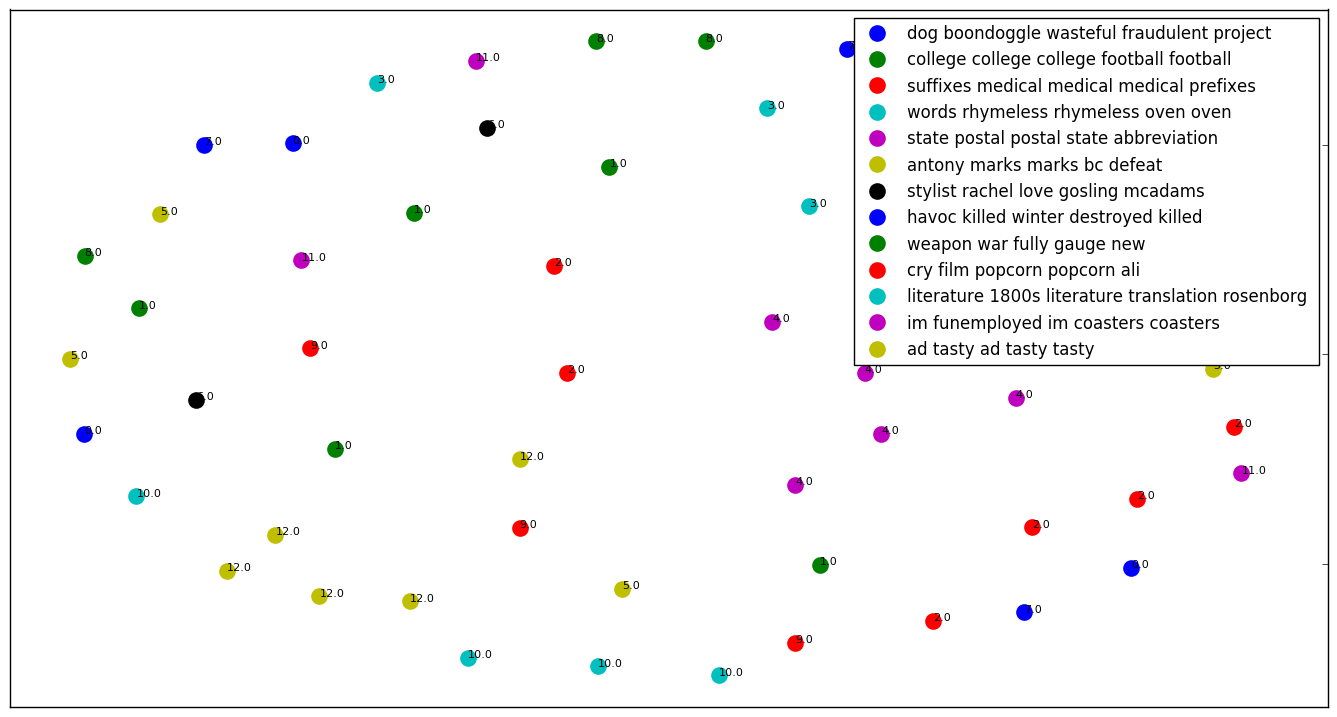

In [126]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
plot_df = pd.DataFrame(dict(x=xs, y=ys, label=one_show_clusters, title=one_show_clusters)) 

#group by cluster
groups = plot_df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=one_cluster_names[name], #color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(plot_df)):
    ax.text(plot_df.ix[i]['x'], plot_df.ix[i]['y'], plot_df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

### Visualization attempts - This is pretty terrible

In [84]:
from sklearn.manifold import TSNE

In [85]:
tsvd_matrix.shape

(216889, 2)

In [125]:
tsne = TSNE()

tsne.fit(tsvd_matrix)
joblib.dump(tsne, 'tsne.pkl')

MemoryError: 

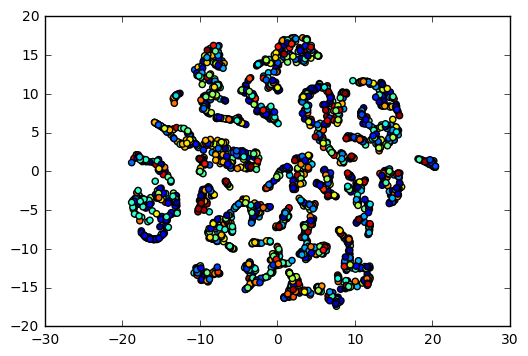

In [70]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(graphing_data[:,0], graphing_data[:,1], c=clusters) 

In [39]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

NameError: name 'dist' is not defined

In [79]:
cluster_dict = dict(zip(range(50), cluster_names))

In [80]:
cluster_dict

{0: 'king bc boy old became ',
 1: 'century law called refers man ',
 2: 'one like makes great round ',
 3: 'back north military vietnams january ',
 4: 'played broadway william roles film ',
 5: 'name take holidays may observances ',
 6: 'new served works parts corn ',
 7: 'president party history us members ',
 8: 'collection little san museum circus ',
 9: 'tv movies stars temple played ',
 10: 'composers born daughter virginia italian ',
 11: 'music piece blue title movies ',
 12: 'unit busy canada unit state ',
 13: 'women last gold wins speed ',
 14: 'country miles spain europe african ',
 15: 'food types drinking small cheese ',
 16: 'island flag jack ship show ',
 17: 'x stand clue crew kelly ',
 18: 'mrs smith book mr joseph ',
 19: 'during camps california wwii sites ',
 20: 'authors john presidential englands why ',
 21: 'means e odd way word ',
 22: 'first pass moor thing became ',
 23: 'dogs sea days one alone ',
 24: 'russian word word means fight ',
 25: 'hall dress bar 

In [81]:
#set up colors per clusters using a dict
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

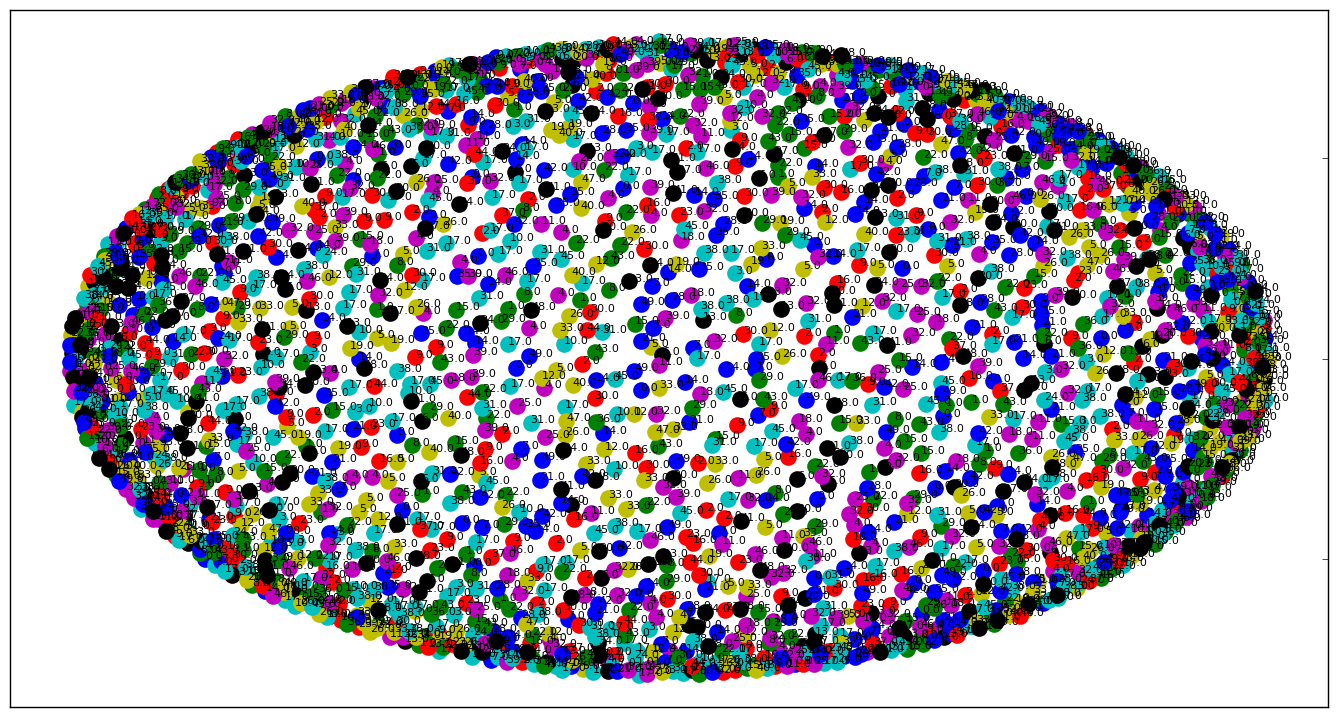

In [83]:
#create data frame that has the result of the MDS plus the cluster numbers and titles
plot_df = pd.DataFrame(dict(x=xs, y=ys, label=clusters, title=clusters)) 

#group by cluster
groups = plot_df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(17, 9)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name], #color=cluster_colors[name], 
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
# ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
for i in range(len(plot_df)):
    ax.text(plot_df.ix[i]['x'], plot_df.ix[i]['y'], plot_df.ix[i]['title'], size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)

### LDA Attempts - work in progress

In [88]:
#strip any proper names from a text...unfortunately right now this is yanking the first word from a sentence too.
def strip_proppers(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.islower()]
#     return "".join([" "+i if not i.startswith("'") and i not in string.punctuation else i for i in tokens]).strip()
    return "".join([" "+i if not i.startswith("'") else i for i in tokens]).strip()

In [89]:
#strip any proper nouns (NNP) or plural proper nouns (NNPS) from a text
from nltk.tag import pos_tag

def strip_proppers_POS(text):
    tagged = pos_tag(text.split()) #use NLTK's part of speech tagger
    non_propernouns = [word for word,pos in tagged if pos != 'NNP' and pos != 'NNPS']
    return non_propernouns

In [90]:
from gensim import corpora, models, similarities 

#remove proper names
%time preprocess = [strip_proppers(doc) for doc in questions]

#tokenize
%time tokenized_text = [tokenize_and_stem(text) for text in preprocess]

#remove stop words
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 41.9 s, sys: 196 ms, total: 42.1 s
Wall time: 41.9 s
CPU times: user 1min 35s, sys: 568 ms, total: 1min 35s
Wall time: 1min 35s
CPU times: user 11.9 s, sys: 128 ms, total: 12.1 s
Wall time: 11.9 s


In [91]:
#create a Gensim dictionary from the texts
dictionary = corpora.Dictionary(texts)

#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
dictionary.filter_extremes(no_below=1, no_above=0.8)

#convert the dictionary to a bag of words corpus for reference
corpus = [dictionary.doc2bow(text) for text in texts]

In [92]:
# %time lda = models.LdaModel(corpus, num_topics=100, id2word=dictionary, update_every=5, chunksize=10000, passes=100)
%time lda = models.LdaModel(corpus, num_topics=num_clusters, id2word=dictionary)

CPU times: user 12min 41s, sys: 10.2 s, total: 12min 51s
Wall time: 12min 46s


In [93]:
len(lda.show_topics(formatted=False, num_words=20))

10

In [94]:
print(lda[corpus[0]])


topics = lda.print_topics(5, num_words=20)

topics_matrix = lda.show_topics(formatted=False, num_words=20)
# topics_matrix

topics_matrix = np.array(topics_matrix)

# topics_matrix.shape

# topic_words = topics_matrix[:,:,1]

# for i in topic_words:
#     print([str(word) for word in i])
#     print()

[(44, 0.11074969936307823), (47, 0.1010000000000001), (58, 0.10100000000000009), (69, 0.49125030063692243), (95, 0.1010000000000001)]


ValueError: setting an array element with a sequence

In [63]:
lda.show_topics()

[(53,
  u'0.117*work + 0.075*hit + 0.054*featur + 0.043*refer + 0.042*major + 0.041*unit + 0.038*well + 0.038*blue + 0.026*michael + 0.021*bob'),
 (21,
  u'0.076*danc + 0.041*cook + 0.035*januari + 0.031*dish + 0.030*egg + 0.027*creatur + 0.025*coach + 0.024*johnni + 0.023*structur + 0.020*name'),
 (69,
  u'0.138*french + 0.074*black + 0.053*north + 0.044*common + 0.033*wear + 0.032*fine + 0.025*name + 0.018*one + 0.017*experi + 0.016*bit'),
 (49,
  u'0.135*wrote + 0.073*start + 0.052*young + 0.040*earth + 0.027*giant + 0.025*wall + 0.021*winter + 0.018*drive + 0.016*fought + 0.015*rome'),
 (62,
  u'0.074*life + 0.061*nicknam + 0.056*kill + 0.054*record + 0.046*fire + 0.041*singer + 0.031*season + 0.031*real + 0.030*control + 0.021*stage'),
 (17,
  u'0.126*presid + 0.084*hous + 0.063*open + 0.053*publish + 0.046*first + 0.034*franc + 0.034*california + 0.030*didnt + 0.028*christma + 0.022*next'),
 (64,
  u'0.081*game + 0.073*bird + 0.030*speci + 0.029*celebr + 0.025*ball + 0.022*festiv

In [75]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
# topics_matrix = np.array(topics_matrix)
topics_matrix

# topic_words = topics_matrix[:,:,1]
# for i in topic_words:
#     print([str(word) for word in i])
#     print()

[(24,
  [(u'number', 0.074651887616095675),
   (u'go', 0.067500155315878829),
   (u'anim', 0.066764931071219932),
   (u'member', 0.052872595387875337),
   (u'marri', 0.048343330490301831),
   (u'father', 0.048274644405873986),
   (u'would', 0.03904432375143442),
   (u'bear', 0.035297687422902506),
   (u'name', 0.026904521019100031),
   (u'episod', 0.017675872586571658),
   (u'card', 0.015804231188876326),
   (u'weather', 0.014128178466196645),
   (u'arthur', 0.013056963259891913),
   (u'whole', 0.012038782614099347),
   (u'properti', 0.0096324251672476255),
   (u'play', 0.00882432226427491),
   (u'edit', 0.0082124164324315994),
   (u'tail', 0.0082050257261730292),
   (u'happen', 0.008122361698017555),
   (u'specif', 0.0078009149336903932)]),
 (15,
  [(u'letter', 0.075913726603678053),
   (u'machin', 0.036683339993086476),
   (u'peter', 0.035247333026815417),
   (u'wine', 0.035142768612363859),
   (u'object', 0.033217077901473824),
   (u'learn', 0.031080948067850625),
   (u'special', 0.

In [251]:
from collections import Counter

counts = Counter(text.split())

In [ ]:
Counter(df[    ])

(-0.5, 399.5, 199.5, -0.5)

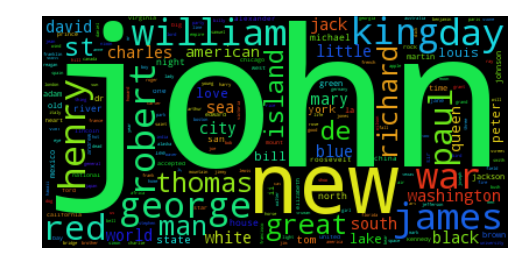

In [261]:
from wordcloud import WordCloud

answers = df['clean_answer'].values
answer_text = ' '.join(answers)

wordcloud = WordCloud().generate(answer_text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(wordcloud)
plt.axis("off")

# # lower max_font_size
# wordcloud = WordCloud(max_font_size=40).generate(text)
# plt.figure()
# plt.imshow(wordcloud)
# plt.axis("off")
# plt.show()

In [264]:
f = open('answers.txt', 'w')
f.write(answer_text.encode('utf8'))
f.close()

(-0.5, 399.5, 199.5, -0.5)

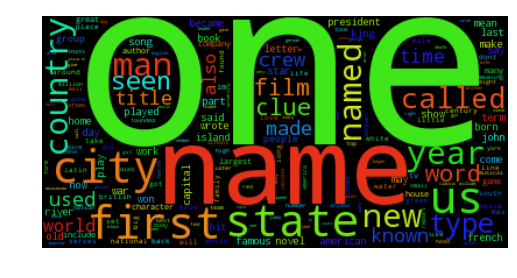

In [260]:
question_text = ' '.join(questions)

wordcloud = WordCloud().generate(question_text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(wordcloud)
plt.axis("off")

(-0.5, 399.5, 199.5, -0.5)

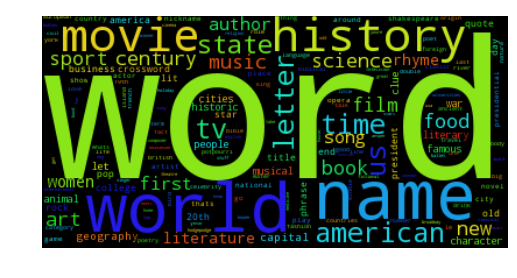

In [262]:
categories = df['clean_category'].values
category_text = ' '.join(categories)

wordcloud = WordCloud().generate(category_text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(wordcloud)
plt.axis("off")

### Dumping cluster text to files

In [127]:
df['Cluster'].value_counts()

76    72355
53     2895
91     2824
59     2801
39     2739
93     2662
90     2658
20     2657
42     2615
5      2601
34     2496
51     2373
1      2299
52     2236
62     2165
23     2133
36     2035
14     2032
82     2019
37     1976
28     1971
86     1970
19     1962
57     1958
12     1933
26     1920
21     1916
16     1890
85     1888
41     1879
      ...  
71     1056
25     1046
80     1035
61     1033
17     1029
8      1027
47     1004
7       998
43      975
79      906
13      896
11      865
77      858
3       837
54      832
44      825
92      812
87      803
89      787
70      769
68      751
45      751
94      725
67      656
49      643
95      492
56      489
97      339
24      281
10        7
Name: Cluster, dtype: int64

In [129]:
top8 = [76, 53, 91, 59, 39, 93, 90, 20]
for num in top8:
    numdf = df[df['Cluster'] == num]
    numtext = numdf['Question'].values
    numtext = ' '.join(numtext)
    f = open('cluster%s.txt' % num, 'w')
    f.write(numtext.encode('utf8'))
    f.close()

In [152]:
from wordcloud import WordCloud, STOPWORDS

def make_wordcloud(num):
    text = open("cluster%s.txt" % num).read()
    stopwords = set(STOPWORDS)
    stopwords.add("href")
    stopwords.add("_blank")
    stopwords.add("jpg")
    stopwords.add("wmv")

    wc = WordCloud(max_words=1000, stopwords=stopwords, margin=10,
               random_state=1).generate(text)
    
    plt.figure()
    plt.imshow(wc.recolor(random_state=3))
    plt.axis("off")
    plt.show()

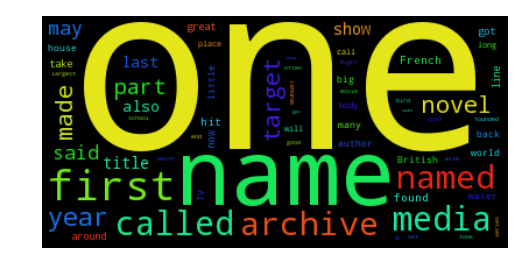

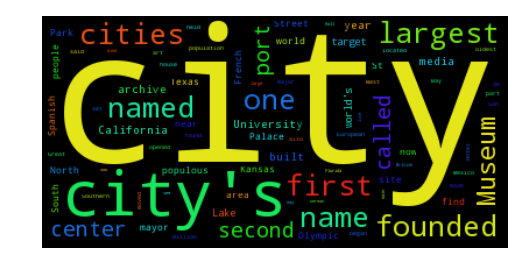

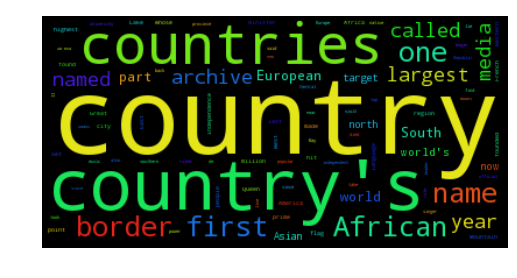

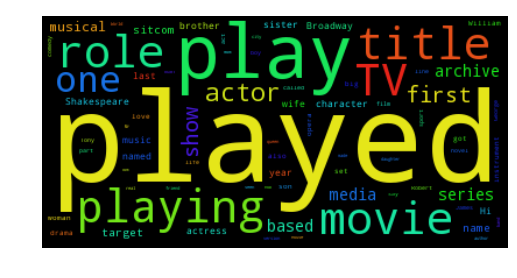

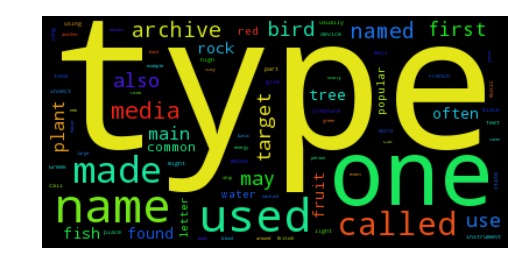

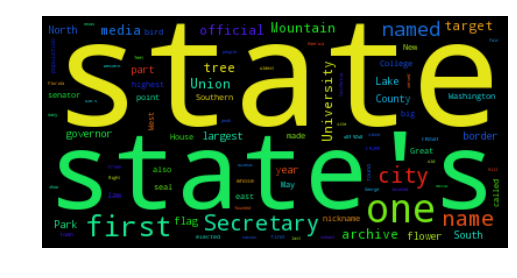

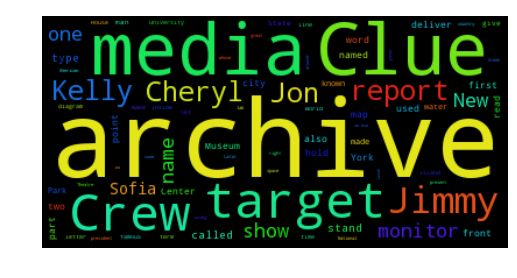

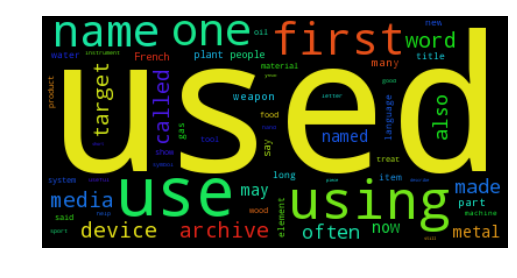

In [153]:
for num in top8:
    make_wordcloud(num)